#  Taxi orders forecasting

The company "X" collected historical data on taxi orders at airports. To attract more drivers during peak load, there is a need to predict the number of taxi orders for the next hour. 

Task: build a model for prediction of the taxi orders amount for the next hour.
Limiation: the value of the *RMSE* metric in the test sample should be no more than 48.

Summarized steps:
1. Downloading the data and resampling it one hour at a time.
2. Analyzing the data.
3. Training of different models with different hyperparameters.
4. Checking the data on the test sample and drawing conclusions.


The data is in the file `taxi.csv'`. The number of orders is in the `num_orders` column.

<h1>Plan<span class="tocSkip"></span></h1>
</ul></li><li><span><a href="#Data preparation" data-toc-modified-id="Data preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Learning stage" data-toc-modified-id="Learning stage-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning stage</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Testing stage" data-toc-modified-id="Testing stage-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing stage</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

## Data preparation

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
def general_analysis(data):
    print(data.info())
    print('__________________________________________________________________________________________________________')
    print(display(data.head(10)))
    print('__________________________________________________________________________________________________________')
    print(display(data.describe()))
    print('__________________________________________________________________________________________________________')
    print('# of missing values:')
    print(data.isna().sum())
    print('__________________________________________________________________________________________________________')

In [4]:
general_analysis(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
__________________________________________________________________________________________________________


num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12

None
__________________________________________________________________________________________________________


num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

None
__________________________________________________________________________________________________________
Количество пропусков:
num_orders    0
dtype: int64
__________________________________________________________________________________________________________


In [5]:
data

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

In [6]:
#resampling
data = data['2018-03-01 00:00:00':'2018-08-31 23:50:00'].resample('1H').sum()
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

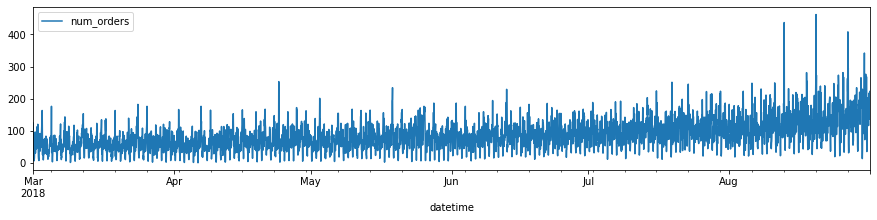

In [7]:
data.plot(figsize=(15,3))
plt.show()

The data has been successfully uploaded, resampled and visualized.

## Analysis

Before working with models, the time series must be checked for stationarity. 

First step: visualizing the data and running the Augmented Dickey–Fuller test.

In [8]:
rolling_mean = data['num_orders'].rolling(20).mean()
rolling_std = data['num_orders'].rolling(20).std()

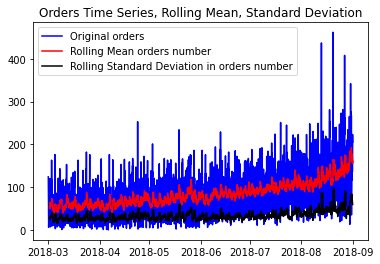

In [9]:
plt.plot(data, color="blue",label="Original orders")
plt.plot(rolling_mean, color="red", label="Rolling Mean orders number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in orders number")
plt.title("Orders Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

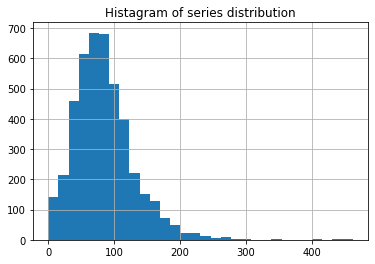

In [10]:
data['num_orders'].hist(bins=30)
plt.title("Histagram of series distribution")
plt.show()

The distribution is close to normal, but has an elongated tail on the right.

In [11]:
decomposed = seasonal_decompose(data)

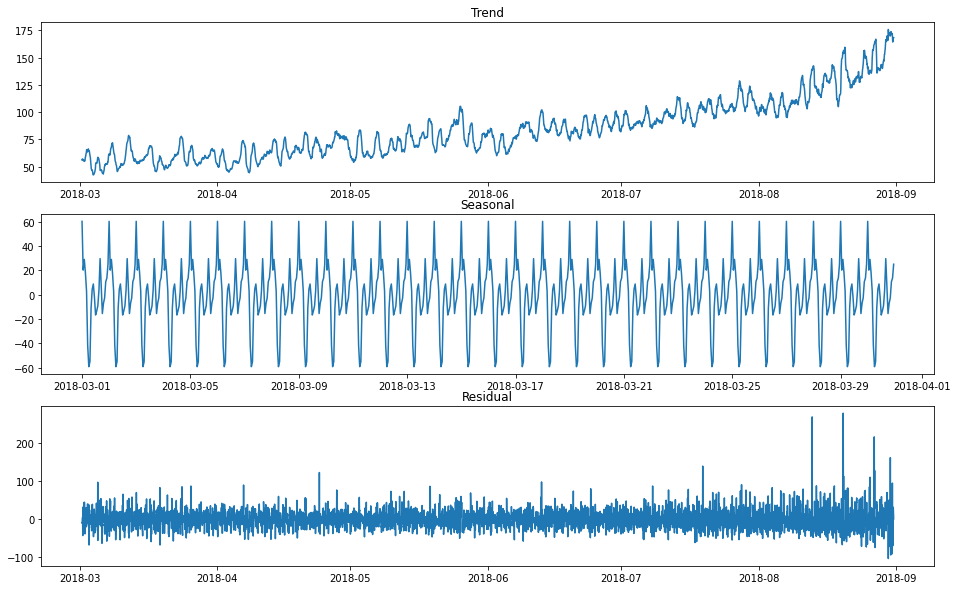

In [12]:
fig, axs = plt.subplots(3, figsize=(16,10))
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal['2018-03-01':'2018-03-30'])
axs[1].set_title("Seasonal")

axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

In [13]:
adft = adfuller(data['num_orders'], autolag="AIC")
adft

(-3.0689242890279558,
 0.028940051402612906,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

The charts show the presence of seasonality. At the same time, after the ADF test, we see that the critical value itself is -3.06, and the p-value is less than 0.05. According to the test results, we can consider the series stationary.

## Learning stage

Сreating the missing features before training, and then finding the best model based on RMSE.

In [14]:
def make_features(data, column, max_lag, rolling_mean_size):
    data_copy = data.copy(deep=True)
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour

    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy[column].shift().rolling(rolling_mean_size).mean()
    
    
    return data_copy

In [16]:
def cv_rmse(model, data, column, n_splits, scoring):
    
    tss = TimeSeriesSplit(n_splits)
    RMSE = 0
    
    for train_index, test_index in tss.split(data):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        X_train = train.drop(column, axis=1)
        y_train = train[column]
        X_test = test.drop(column, axis=1)
        y_test = test[column]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        RMSE += mean_squared_error(y_test, pred) ** 0.5
        
    return RMSE / n_splits

### Linear Regression

In [17]:
values = [i for i in range(1, 100)]
for p in values:
    for q in values:
        data_arma = make_features(data, 'num_orders', p, q)
        
        train, test = train_test_split(data_arma, shuffle=False, test_size=0.1, random_state=42)
        train.dropna(inplace=True)

        X_train = train.drop("num_orders", axis=1)
        y_train = train["num_orders"]
        X_test = test.drop("num_orders", axis=1)
        y_test = test["num_orders"]
        
        model_lin = LinearRegression()
        
        cv_best = cv_rmse(model = model_lin,
                          data = train, 
                          column = 'num_orders', 
                          n_splits = 5, 
                          scoring = "neg_mean_squared_error")
        
        p_best = p
        q_best = q
            
print("RMSE:", cv_best)
print(p_best)
print(q_best)

/tmp/ipykernel_48/205585013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_48/205585013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_48/205585013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_48/205585013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

RMSE: 24.16946702147198
99
99


In [18]:
pred_best = model_lin.predict(X_train)

RMSE_lin = mean_squared_error(y_train, pred_best) ** 0.5
print(RMSE_lin)

22.260531749864636


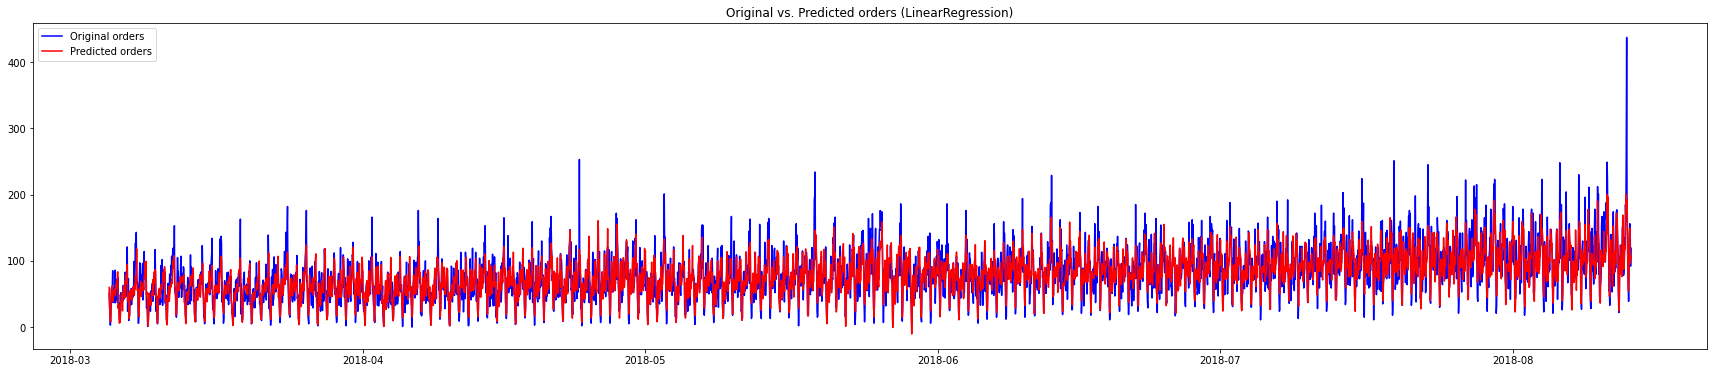

In [19]:
pred_best = model_lin.predict(X_train)
plt.figure(figsize=(30,6))
plt.plot(X_train.index, y_train, color="blue",label="Original orders")
plt.plot(X_train.index, pred_best, color="red", label="Predicted orders")
plt.title("Original vs. Predicted orders (LinearRegression)")
plt.legend(loc="best")
plt.show()

### LightGBM

In [21]:
model_lgbm = LGBMRegressor() 
params_lgbm = [{'num_leaves':[50, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42]}]

tss_split = TimeSeriesSplit(n_splits=5)

lgbm = GridSearchCV(model_lgbm, params_lgbm, scoring='neg_mean_squared_error', cv =tss_split )
lgbm.fit(X_train, y_train)

print(lgbm.best_params_)

means = lgbm.cv_results_['mean_test_score']
RMSE_lgbm = (max(means)*-1) ** 0.5
print(RMSE_lgbm)

{'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 42}
24.11392030900771


In [31]:
model_lgbm_best = LGBMRegressor(learning_rate=0.1,num_leaves=100, random_state=42)
cv_lgbm_best = cv_rmse(model = model_lgbm_best,
                          data = train, 
                          column = 'num_orders', 
                          n_splits = 5, 
                          scoring = "neg_mean_squared_error")
print('RMSE for CatBoost:', cv_lgbm_best)

RMSE for CatBoost: 23.887695722504112


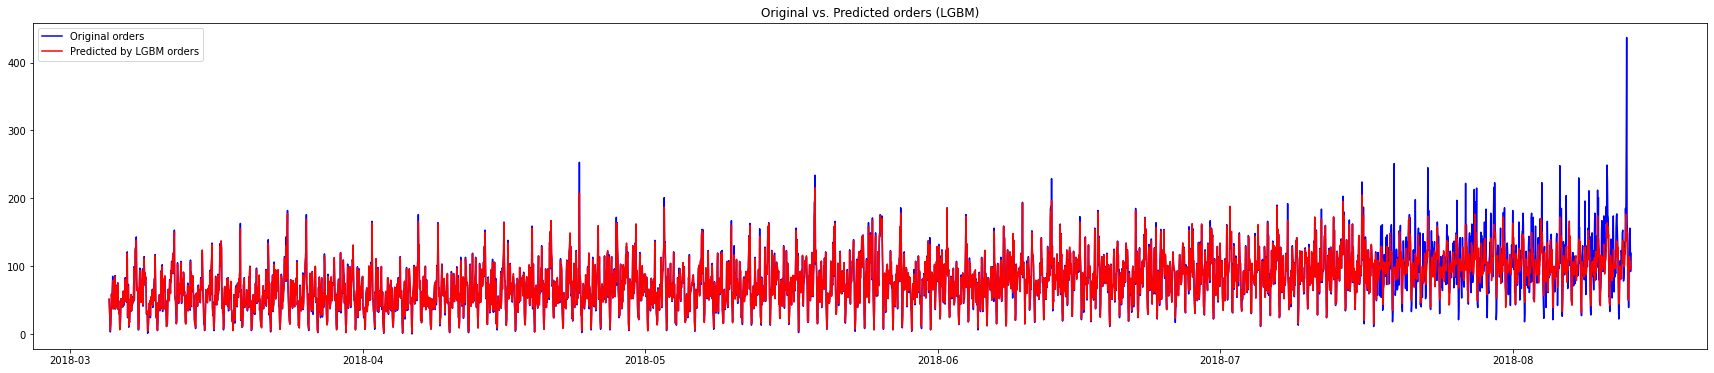

In [32]:
pred_lgbm = model_lgbm_best.predict(X_train)

plt.figure(figsize=(30,6))
plt.plot(X_train.index, y_train, color="blue",label="Original orders")
plt.plot(X_train.index, pred_lgbm, color="red", label="Predicted by LGBM orders")
plt.title("Original vs. Predicted orders (LGBM)")
plt.legend(loc="best")
plt.show()

### CatBoostRegressor

In [24]:
model_cb = CatBoostRegressor() 
params_cb = [{'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42],
                'verbose':[0]}]

cb = GridSearchCV(model_cb, params_cb, scoring='neg_mean_squared_error',cv =tss_split)
cb.fit(X_train, y_train)

print(cb.best_params_)

means = cb.cv_results_['mean_test_score']
RMSE_cb = (max(means)*-1) ** 0.5
print(RMSE_cb)

{'learning_rate': 0.1, 'random_state': 42, 'verbose': 0}
23.804603231258543


In [33]:
model_cb_best = CatBoostRegressor(learning_rate=0.1, random_state=42, verbose=0)
cv_cb_best = cv_rmse(model = model_cb_best,
                          data = train, 
                          column = 'num_orders', 
                          n_splits = 5, 
                          scoring = "neg_mean_squared_error")
print('RMSE for CatBoost:', cv_cb_best)

RMSE for CatBoost: 23.527547824700726


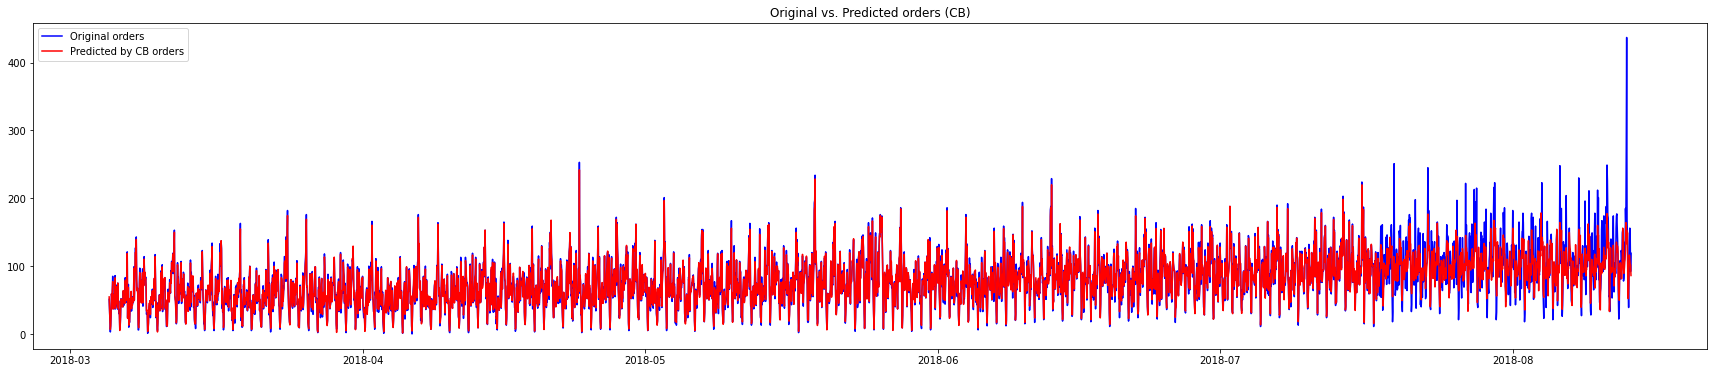

In [34]:
pred_cb = model_cb_best.predict(X_train)

plt.figure(figsize=(30,6))
plt.plot(X_train.index, y_train, color="blue",label="Original orders")
plt.plot(X_train.index, pred_cb, color="red", label="Predicted by CB orders")
plt.title("Original vs. Predicted orders (CB)")
plt.legend(loc="best")
plt.show()

In [37]:
models_data = [[22.3],
                    [23.9],
                    [23.5]]

model_comparison = pd.DataFrame(data=models_data, index=["LinearRegression", "LightGBM", "CatBoost"],columns=["Model RMSE"])
model_comparison

Model RMSE
LinearRegression        22.3
LightGBM                23.9
CatBoost                23.5

As a result, Linear Regression wins out of the three models considered from the point of view of the RMSE metric.

## Testing stage

Checking the resulting best model on a test sample.

In [38]:
pred_test = model_lin.predict(X_test)

rmse_test = mean_squared_error(y_test, pred_test)**0.5
print('RMSE (test sample):',rmse_test.round())

RMSE (test sample): 44.0


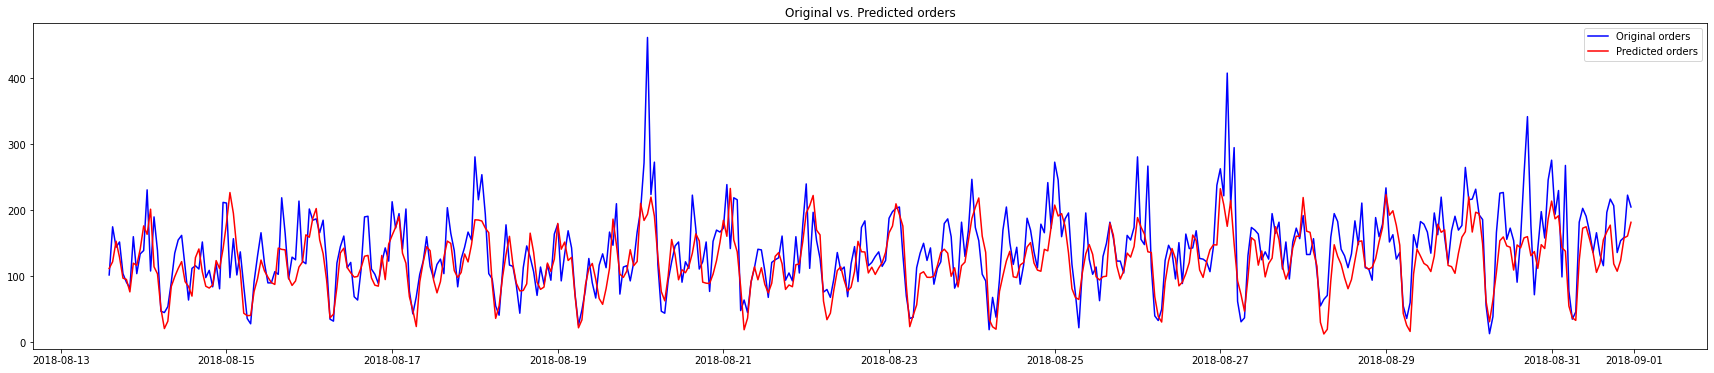

In [39]:
plt.figure(figsize=(30,6))
plt.plot(X_test.index, y_test, color="blue",label="Original orders")
plt.plot(X_test.index, pred_test, color="red", label="Predicted orders")
plt.title("Original vs. Predicted orders")
plt.legend(loc="best")
plt.show()

## Conclusion

Finally, the following steps were completed and the following results were obtained:

* The data has been uploaded and analyzed. 
* The data has been checked for stationarity.
* The best model has been found and tested.
* As a result, RMSE less than 48 was obtained.